<a href="https://colab.research.google.com/github/saranrajeswar/Machine-Learning-with-Python/blob/master/Skincancerdetectionwithdeeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First of all we need to import packages
# Necessary packages are imported below


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

As a .csv file it doesn't support multiple images in classification we use .npz file from https://zenodo.org/ which gives .npz file format for feeding images as dataset. 

In [3]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2022-05-07 13:49:22--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  13.4MB/s    in 1.4s    

2022-05-07 13:49:25 (13.4 MB/s) - ‘Data.npz’ saved [19725078/19725078]



The .npz is a data preprocessed file so we need not to filter the dataset, as it was a processed one.
We can view the classified contents by below code 

In [4]:
data = np.load('Data.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


To  the count of test,validate,train dataset it originally consists about 28*28 images we need to reshape to (1) so the system can categorized the dataset as an array.

In [5]:
print(f'Train Set:      X:%s Y:%s' %(data['train_images'].shape, data['train_labels'].shape))
print(f'Validation Set: X:%s Y:%s' %(data['val_images'].shape, data['val_labels'].shape))
print(f'Test Set :      X:%s Y:%s' %(data['test_images'].shape, data['test_labels'].shape))

Train Set:      X:(7007, 28, 28, 3) Y:(7007, 1)
Validation Set: X:(1003, 28, 28, 3) Y:(1003, 1)
Test Set :      X:(2005, 28, 28, 3) Y:(2005, 1)


In [11]:
X_train = data['train_images']
X_val = data['val_images']
X_test = data['test_images']
X = np.concatenate((X_train, X_val, X_test), axis=0)

y_train = data['train_labels']
y_val = data['val_labels']
y_test = data['test_labels']
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [12]:
labels = ['akiec',
          'bcc',
          'bkl',
          'df',
          'nv',
          'vasc',
          'mel']

In [13]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}

np.unique(y)



array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [14]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,327
bcc,514
bkl,1099
df,115
nv,1113
vasc,6705
mel,142


You may wonder how the dataset in array format can be represented, but it is actually is, we could visualize the sample set of images from the dataset below. 

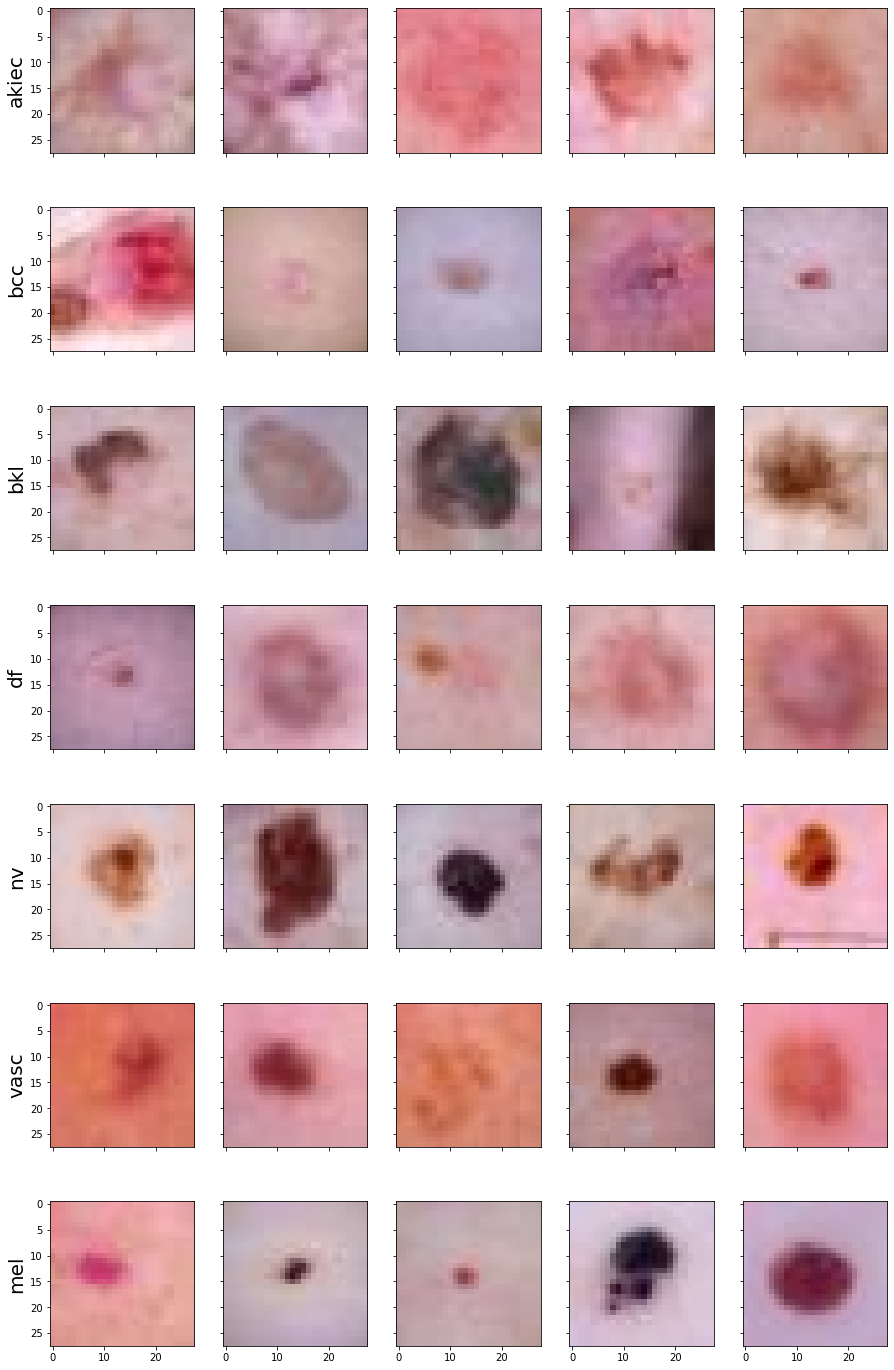

In [15]:
fig, ax = plt.subplots(7, 5)
fig.set_figheight(25)
fig.set_figwidth(15)
for classes in range (7):
  for i, inx in enumerate(np.where(y==classes)[0][:5]):
    ax[classes,i].imshow(X[inx])
    ax[classes,i].set_ylabel(labels[classes],fontsize = 20.0)
    ax[classes,i].label_outer()

In [16]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y_train==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,228
bcc,359
bkl,769
df,80
nv,779
vasc,4693
mel,99


In [17]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

os_dict = {0: num_classes[0]*7,
           1: num_classes[1]*5,
           2: 1500,
           3: 2500,
           4: 1500,
           5: num_classes[5],
           6: 1500}
oversample = RandomOverSampler(sampling_strategy=os_dict)
oversampled_X , oversampled_y = oversample.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
print('OS_X:%s OS_y:%s' %(oversampled_X.shape, oversampled_y.shape))

us_dict = {0: num_classes[0]*7,
           1: num_classes[1]*5,
           2: 1500,
           3: 2500,
           4: 1500,
           5: 3000,
           6: 1500}

undersample = RandomUnderSampler(sampling_strategy=us_dict)
undersampled_X , undersampled_y = undersample.fit_resample(oversampled_X, oversampled_y)
print('US_X:%s US_y:%s' %(undersampled_X.shape, undersampled_y.shape))



OS_X:(15084, 2352) OS_y:(15084,)
US_X:(13391, 2352) US_y:(13391,)


In [18]:
undersampled_y.shape

(13391,)

In [19]:
undersampled_X = undersampled_X.reshape(-1,28,28,3)

In [20]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(undersampled_y==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,1596
bcc,1795
bkl,1500
df,2500
nv,1500
vasc,3000
mel,1500


In [21]:
from tensorflow.keras.utils import to_categorical
undersampled_y = to_categorical(undersampled_y)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

undersampled_y.shape



(13391, 7)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'wrap')

batch_size=50
train_data = train_datagen.flow(undersampled_X, undersampled_y, batch_size = batch_size, seed=1)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_data = test_datagen.flow(X_val, y_val, batch_size=batch_size,seed=1)

print(f'Train Set:      X:%s Y:%s' %(train_data.x.shape, train_data.y.shape))
print(f'Validation Set: X:%s Y:%s' %(val_data.x.shape, val_data.y.shape))
print(f'Test Set :      X:%s Y:%s' %(X_test.shape, y_test.shape))



Train Set:      X:(13391, 28, 28, 3) Y:(13391, 7)
Validation Set: X:(1003, 28, 28, 3) Y:(1003, 7)
Test Set :      X:(2005, 28, 28, 3) Y:(2005, 7)


In [23]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(np.argmax(val_data.y, axis=1)==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,33
bcc,52
bkl,110
df,12
nv,111
vasc,671
mel,14


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

input_layer = Input(shape=(28,28,3))

# convolution block 1 
cb11 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(input_layer)
cb12 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb11)
maxpl1 = MaxPool2D((2,2))(cb12)

#convolution block 2 
cb21 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl1)
cb22 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb21)
maxpl2 = MaxPool2D((2,2))(cb22)

#convolution block 3
cb31 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl2)
cb32 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb31)
maxpl3 = MaxPool2D((2,2))(cb32)

#convolution block 4
cb41 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(maxpl3)
cb42 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb41)
cb43 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(cb42)
maxpl4 = MaxPool2D((2,2))(cb43)

# artificial neural network block
flat   = Flatten()(maxpl4)
dense1 = Dense(1024, activation="relu")(flat)
dense2 = Dense(1024, activation="relu")(dense1)
dense3 = Dense(1024, activation="relu")(dense2)
output = Dense(7, activation="softmax")(dense3)
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer= keras.optimizers.Adam(0.0001, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])#keras.metrics.Accuracy())

batch_size = batch_size
epochs = 30
model_history = model.fit(train_data,
                          steps_per_epoch= int(train_data.n/batch_size),
                          epochs=epochs,
                          validation_data=val_data,
                          validation_steps=int(val_data.n/batch_size))



In [ ]:
model_history.params

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 256)       7168      
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 256)       590080    
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 256)       590080    
                                                           

# Flow of process is depicted using **plot_model** an feature from Tensorflow.

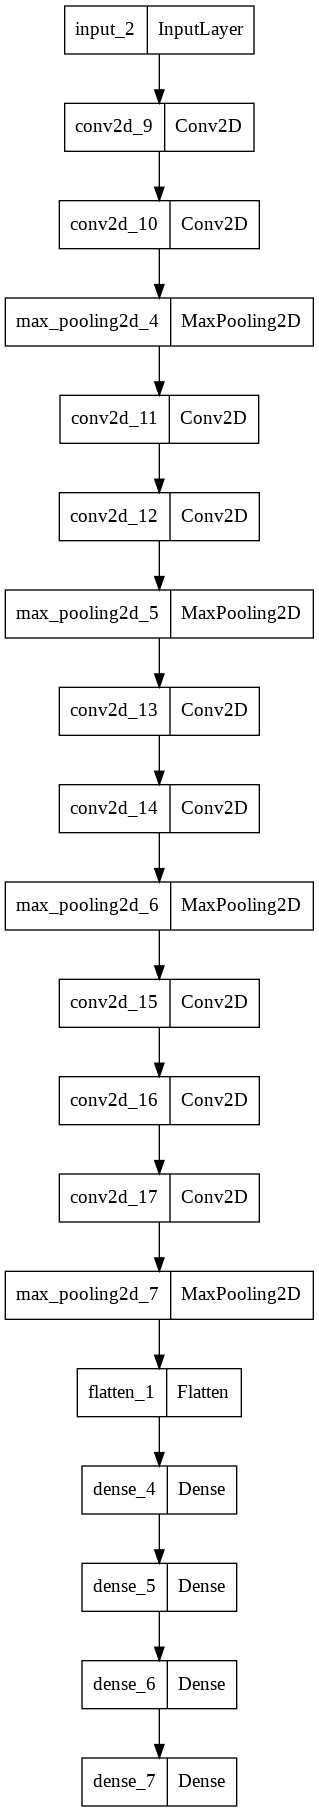

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [27]:
model.evaluate(X_test/255, y_test)

63/63 [==============================] - 48s 750ms/step - loss: 1.9388 - acc: 0.6688


[1.938781499862671, 0.6688279509544373]

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [29]:
y_proba = model.predict(X_test/255)
y_proba.round(2)

array([[0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       ...,
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14],
       [0.14, 0.14, 0.14, ..., 0.14, 0.14, 0.14]], dtype=float32)

In [30]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred[:10]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [31]:
y_pred_name = np.array(labels)[y_pred]
y_pred_name[:10]

array(['vasc', 'vasc', 'vasc', 'vasc', 'vasc', 'vasc', 'vasc', 'vasc',
       'vasc', 'vasc'], dtype='<U5')

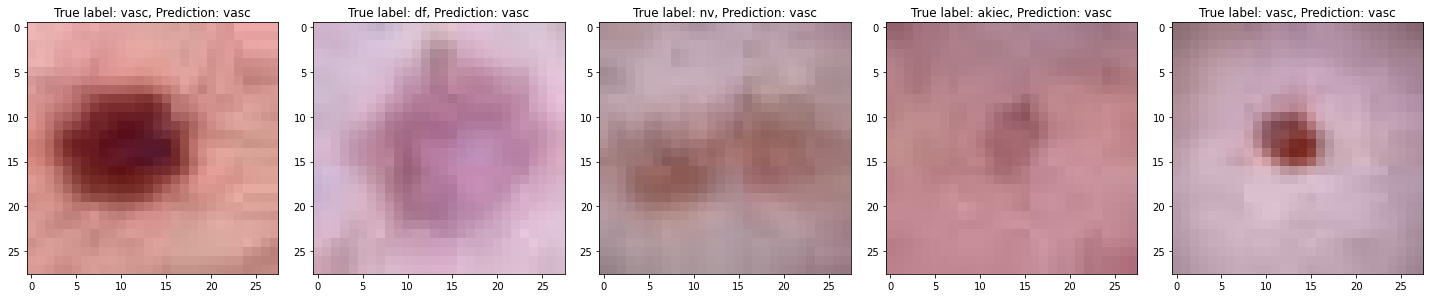

In [32]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[i])
    plt.title('True label: {}, Prediction: {}'.format(labels[y_test[i].argmax()], y_pred_name[i]))
plt.tight_layout()   

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

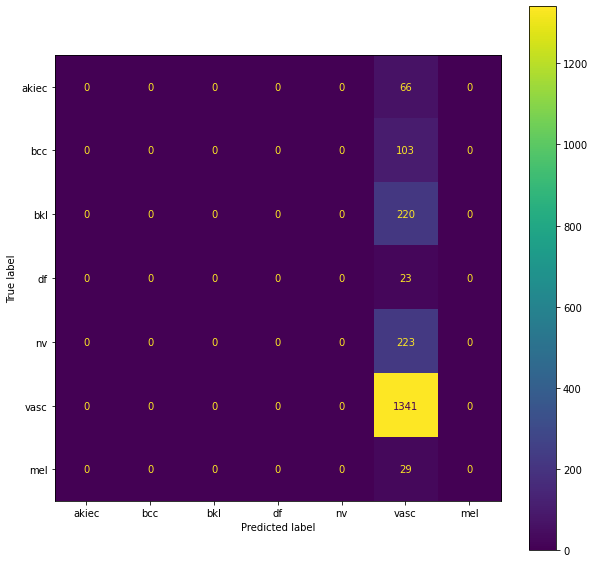

In [34]:
y_test_numbers = np.array([y.argmax() for y in y_test])

cm = confusion_matrix(y_test_numbers, y_pred)

cm_display = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)



In [35]:
print(classification_report(y_test_numbers, y_pred, target_names = labels))

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
          nv       0.00      0.00      0.00       223
        vasc       0.67      1.00      0.80      1341
         mel       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
model.layers

In [37]:
first_conv = model.layers[1]
print(first_conv)
print(first_conv.weights)

[<tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 3, 256) dtype=float32, numpy=
array([[[[ 0.03523294,  0.00832379,  0.00566302, ...,  0.00960422,
           0.03123721, -0.04448124],
         [-0.05003769, -0.01256904, -0.00606512, ...,  0.02042768,
          -0.00191562, -0.04005025],
         [ 0.03715238,  0.03626291, -0.04203849, ..., -0.01107786,
           0.00295016, -0.02674719]],

        [[ 0.02507648, -0.02505111, -0.04139812, ..., -0.00767222,
          -0.00624712,  0.02321715],
         [-0.01317182, -0.03481111,  0.00377929, ...,  0.01571365,
          -0.0034369 ,  0.01233818],
         [ 0.04255366,  0.04314999, -0.01043721, ...,  0.02134035,
           0.0497683 ,  0.04763363]],

        [[-0.01611324,  0.01857644,  0.02308534, ..., -0.03613341,
           0.03769856, -0.00955249],
         [-0.02020237,  0.005524  ,  0.03698441, ...,  0.0299736 ,
           0.0145901 ,  0.03377458],
         [-0.00195117,  0.03902128,  0.02795264, ..., -0.02007299,
           0.0026026

In [39]:
print('Output Shape of the first Convolution layer: ',first_conv(X_test/255).shape)
print('Number of Testset data:                      ',first_conv(X_test/255).shape[0])
print('Number of first Convolution layer:           ',first_conv(X_test/255).shape[3])

Output Shape of the first Convolution layer:  (2005, 28, 28, 256)
Number of Testset data:                       2005
Number of first Convolution layer:            256


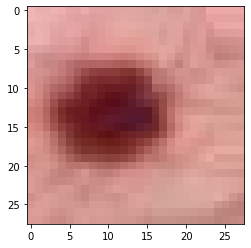

In [40]:
n = 0
plt.imshow(X_test[n])

(28, 28, 256)


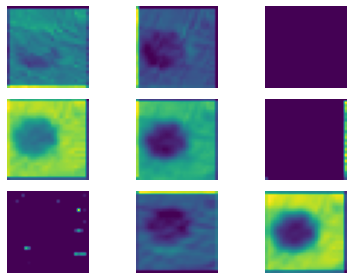

In [41]:
#first layer output
current_layer_output = first_conv(X_test/255)[n]
print(current_layer_output.shape)
fig, ax = plt.subplots(3, 3)
for i in range(9):
  ax[i//3][i%3].imshow(current_layer_output[:,:,i])
  ax[i//3][i%3].axis('off')
plt.tight_layout()